In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import pickle as pickle
import glob
%matplotlib inline

In [3]:
ls

camera_cal/               harder_challenge_video.mp4   settings.py
Camera Calibration.ipynb  Image_Gen.ipynb              test_images/
camera_calibration.p      output_images/               test_images_viv/
challenge_video.mp4       Perspective_transform.ipynb  tracker.py
examples/                 project_video.mp4            Vanishing_point.png
example_writeup.pdf       __pycache__/                 vp_visualization.png
Experimenting.ipynb       README.md                    writeup_template.md


In [4]:
data = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = data['mtx']
dist = data['dist']


In [5]:
ls camera_cal/

calibration10.jpg  calibration15.jpg  calibration1.jpg   calibration5.jpg
calibration11.jpg  calibration16.jpg  calibration20.jpg  calibration6.jpg
calibration12.jpg  calibration17.jpg  calibration2.jpg   calibration7.jpg
calibration13.jpg  calibration18.jpg  calibration3.jpg   calibration8.jpg
calibration14.jpg  calibration19.jpg  calibration4.jpg   calibration9.jpg


In [6]:
img = mpimg.imread('camera_cal/calibration1.jpg')

#### Show effect of undistortion

In [7]:
undist = cv2.undistort(img, mtx, dist, None, mtx)

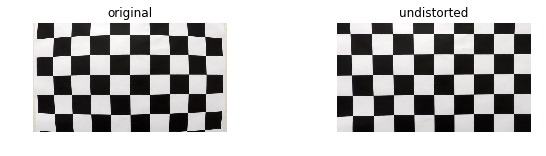

In [8]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off');
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(undist)
plt.title('undistorted')
plt.axis('off');

### Function definitions

Sobel

In [9]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

Magnitude of the gradient

In [10]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # sobel x and y
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)

    sobel_xy = np.sqrt(sobelx**2 + sobely**2)
    print('sobel_xy: ', sobel_xy)
    print(':: ',np.max(sobel_xy, axis = 0))
    print('sobel_xy: ', sobel_xy.shape)
    sf = np.max(sobel_xy/255)
    gradmag = (sobel_xy/sf).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

Direction of the gradient

In [11]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_x= np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    
    
    direction = np.arctan2(abs_y, abs_x)
    
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

#### Color gradient

color gradient selection

In [12]:
def color_threshold(img, sthresh=(0, 255), vthresh = (0, 255)):
    """
    This function takes in two thresholds, s in HLS and v in HSV and the image and it 
    returns the combination output binary of both gradients
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    
    # s channel
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s > sthresh[0]) & (s <= sthresh[1])] = 1
    
    # v channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # isolate v channel
    v = hsv[:,:,2]
    v_binary = np.zeros_like(v)
    v_binary[(v > vthresh[0]) & (v <= vthresh[1])] = 1

    # create combination of both binaries as output
    output_binary = np.zeros_like(s)
    output_binary[(s_binary == 1) | (v_binary == 1)] = 255

    return output_binary

#### Perspective Transform

#### Color Mask

#### Combine masks

#### Sobel Filters

In [12]:
cd test_images/

/home/jonathanmitchell/Documents/Advanced-Lane-Line/Advanced-Lane-Line-Detection/test_images


In [13]:
rm tracked*

In [14]:
rm perspective*

In [15]:
ls

straight_lines1.jpg  test1.jpg  test3.jpg  test5.jpg
straight_lines2.jpg  test2.jpg  test4.jpg  test6.jpg


In [16]:
cd ..

/home/jonathanmitchell/Documents/Advanced-Lane-Line/Advanced-Lane-Line-Detection


In [17]:
pwd

'/home/jonathanmitchell/Documents/Advanced-Lane-Line/Advanced-Lane-Line-Detection'

In [18]:
test_images_created = False

In [24]:
if test_images_created is False:
    for idx, fname in enumerate(glob.glob('test_images/*.jpg')):
        # read in the image
        img = cv2.imread(fname)
        
        # undistort the image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # preprocessing

        # grab single channel of the image
        preprocessImage = np.zeros_like(img[:,:,0])

        # apply sobel gradient x thresholds
        gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)

        # apply sobel gradient y thresholds
        grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)

        # apply color gradient threshold
        c_binary = color_threshold(img, sthresh = (100, 255), vthresh=(50, 255))


        
        # apply all three thresholds to preprocessImage and set true's to 1
        preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 150
        
        
        
        
        # create write name of the image
        write_name_tracked = './test_images/tracked' + str(idx) + '.jpg'
        result = preprocessImage
        
        # perspective transform the image using warper
        perspective = warper(preprocessImage, M)
        write_name_perspective = './test_images/perspective' + str(idx) + '.jpg'
        
        # write gradient image (edges)
        cv2.imwrite(write_name_tracked, result)
        
        # write perspective image (warped)
        cv2.imwrite(write_name_perspective, perspective)
        
test_images_created = True

if test_images_created is True:
    print('test_images have already been created')

    

test_images have already been created


#### Perspective Transform

#### Src and Dst points

In [20]:
   
# top_left_src = [550, 480] # blue tri    OLD v1
# top_left_src = [585, 460] # blue tri OLD v2

# top_right_src = [695, 460] # cyan tri
# bot_left_src = [203, 720] # red tri
# bot_right_src = [1127, 720] # green tri

# new values
# top_left_src = [480, 480] # blue tri
# top_right_src = [800, 480] # cyan tri
# bot_left_src = [0, 720] # red tri
# bot_right_src = [1280, 720] # green tri


src = np.float32([top_left_src, top_right_src, bot_right_src, bot_left_src])

top_left_dst = [320, 0] #blue tri OLD v1
top_right_dst = [960, 0] # cyan tri
bot_left_dst = [320, 720] # red tri
bot_right_dst = [960, 720] # green tri




dst = np.float32([top_left_dst, top_right_dst, bot_right_dst, bot_left_dst])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


In [21]:
def warper(img, M):
    img_size = (img.shape[1], img.shape[0])    

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped

def warper_plot(image, warped):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()



    ax1.set_title('source image')
    ax1.imshow(image)
    ax2.set_title('warped image')
    ax2.imshow(warped)

### Show postprocessed results

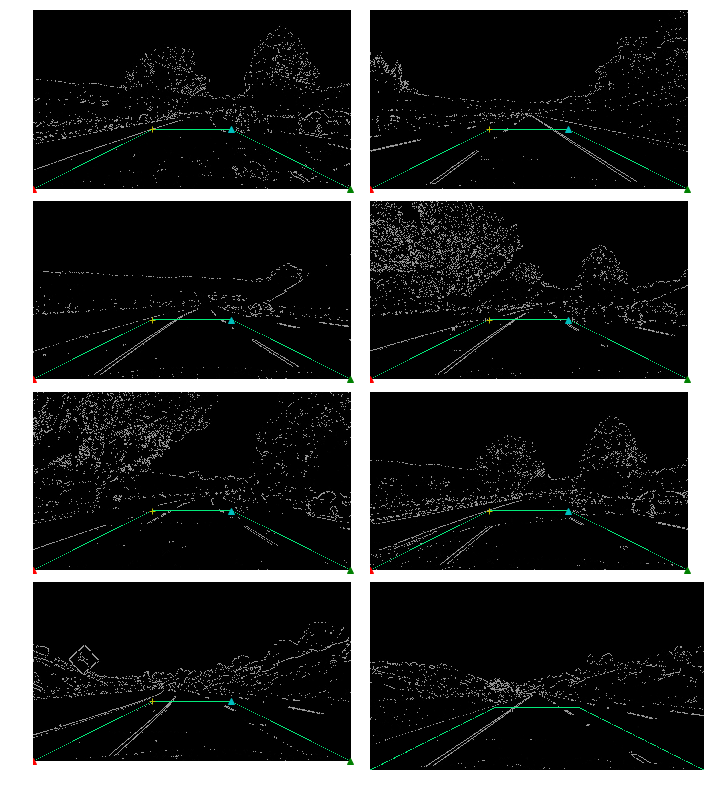

In [25]:
plt.figure(figsize=(12,14))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(wspace = 0.01, hspace = 0.01)
    
for idx, fname in enumerate(glob.glob('test_images/tracked*.jpg')):
    
    # perspective transform points
    color=[2, 234, 122] 
    thickness=2
    
    plt.plot(top_left_src[0],top_left_src[1], 'y+')
    plt.plot(top_right_src[0], top_right_src[1], 'c^')
    plt.plot(bot_left_src[0], bot_left_src[1], 'r^')
    plt.plot(bot_right_src[0], bot_right_src[1], 'g^')

    
    
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # draw lines connecting the vertices
    
    img = cv2.line(img, (top_left_src[0], top_left_src[1]), 
         (top_right_src[0], top_right_src[1]), color, thickness)
    
    img = cv2.line(img, (top_right_src[0], top_right_src[1]), 
         (bot_right_src[0], bot_right_src[1]), color, thickness)
    
    img = cv2.line(img, (bot_right_src[0], bot_right_src[1]), 
         (bot_left_src[0], bot_left_src[1]), color, thickness)
    
    img = cv2.line(img,   (bot_left_src[0], bot_left_src[1]), 
         (bot_right_src[0], bot_right_src[1]), color, thickness)
    
    
    
    img = cv2.line(img,   (bot_left_src[0], bot_left_src[1]), 
         (top_left_src[0], top_left_src[1]), color, thickness)
    
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.imshow(img)
plt.show()

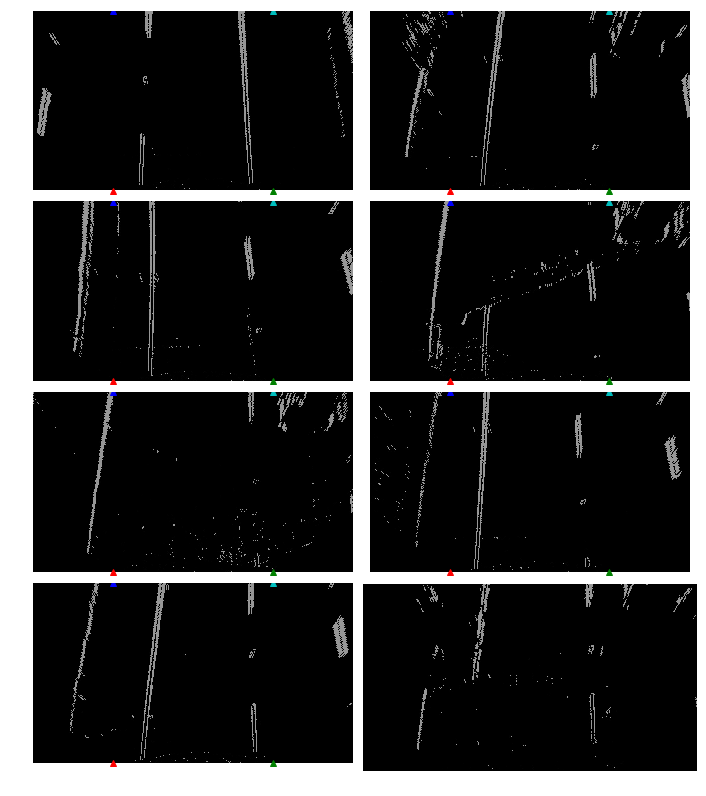

In [26]:
plt.figure(figsize=(12,14))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(wspace = 0.01, hspace = 0.01)
    
for idx, fname in enumerate(glob.glob('test_images/perspective*.jpg')):
    
    # destination points


    plt.plot(top_left_dst[0], top_left_dst[1], 'b^')
    plt.plot(top_right_dst[0], top_right_dst[1], 'c^')
    plt.plot(bot_left_dst[0], bot_left_dst[1], 'r^')
    plt.plot(bot_right_dst[0], bot_right_dst[1], 'g^')
    
    
    
    
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.imshow(img)
plt.show()


#### Window Creation